In [1]:
#Linear regression
from sklearn.linear_model import LinearRegression

#Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import csv
import pandas as pd
from collections import defaultdict
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

In [2]:
rosettes = [3,6,7,11,12,13,14,15,18,19]

### Create graph

In [3]:
def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))
                n.append(float(values[-1]))
                nodes.append(n)

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

In [4]:
nodes, edges, distances = graph_r(rosettes[0])

### Correlation matrix

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_2376/1444036664.py:8: RuntimeWarning: divide by zero encountered in log10
  ed = [np.log10(c[n[0]]) for n in nodes]


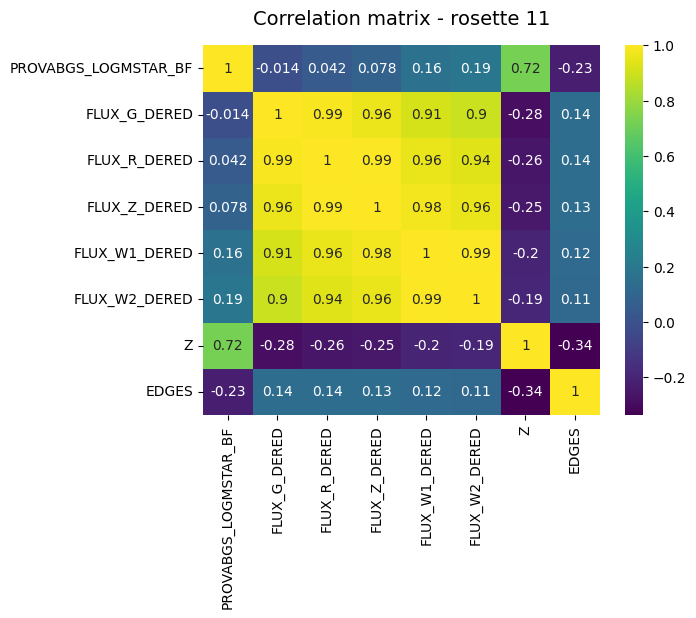

In [5]:
def correlation_matrix(r,nodes,edges):

    df = pd.read_csv(f'./data/rosette{r}_nodes.csv')
    c = defaultdict(int)
    for edge in edges:
        c[edge[0]] += 1
        c[edge[1]] += 1
    ed = [np.log10(c[n[0]]) for n in nodes]
    df['EDGES'] = ed

    df.drop('TARGET_ID', axis=1, inplace=True)
    matrix = sb.heatmap(df.corr(), cmap="viridis", annot=True)
    matrix.set_title(f'Correlation matrix - rosette {r}', fontsize=14, pad=15)
    plt.show()

nodes, edges, _ = graph_r(11)
correlation_matrix(11,nodes,edges)

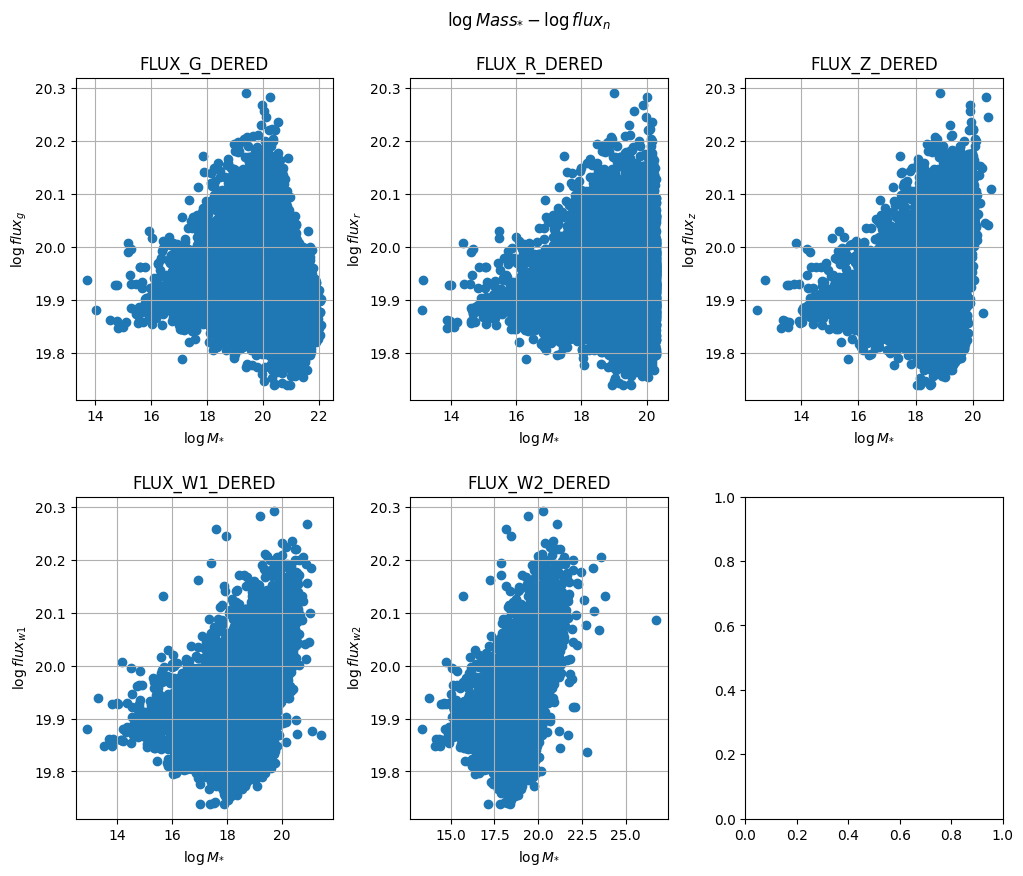

In [6]:
nodes, edges, _ = graph_r(11)

c = defaultdict(int)
for edge in edges:
    c[edge[0]] += 1
    c[edge[1]] += 1
m = [n[1] for n in nodes]
ed = [c[n[0]] for n in nodes]

f_g = [n[2] for n in nodes]
f_r = [n[3] for n in nodes]
f_z = [n[4] for n in nodes]
f_w1 = [n[5] for n in nodes]
f_w2 = [n[6] for n in nodes]

cmap = cm.viridis
n = (m - np.min(m)) / (np.max(m) - np.min(m))
min_norm = np.min(m)
max_norm = np.max(m)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_norm, vmax=max_norm))
sm.set_array([])

nrows, ncols =  3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'$\log{Mass_{*}} - \log{flux_{n}}$', y=1.06)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

axes[0, 0].scatter(f_g, m, marker='o')
axes[0, 0].set_title('FLUX_G_DERED')
axes[0, 0].set_xlabel(r'$\log M_{*}$')
axes[0, 0].set_ylabel(r'$\log flux_{g}$')
axes[0, 0].grid()

axes[0, 1].scatter(f_r, m, marker='o')
axes[0, 1].set_title('FLUX_R_DERED')
axes[0, 1].set_xlabel(r'$\log M_{*}$')
axes[0, 1].set_ylabel(r'$\log flux_{r}$')
axes[0, 1].grid()

axes[0, 2].scatter(f_z, m, marker='o')
axes[0, 2].set_title('FLUX_Z_DERED')
axes[0, 2].set_xlabel(r'$\log M_{*}$')
axes[0, 2].set_ylabel(r'$\log flux_{z}$')
axes[0, 2].grid()

axes[1, 0].scatter(f_w1, m, marker='o')
axes[1, 0].set_title('FLUX_W1_DERED')
axes[1, 0].set_xlabel(r'$\log M_{*}$')
axes[1, 0].set_ylabel(r'$\log flux_{w1}$')
axes[1, 0].grid()

axes[1, 1].scatter(f_w2, m, marker='o')
axes[1, 1].set_title('FLUX_W2_DERED')
axes[1, 1].set_xlabel(r'$\log M_{*}$')
axes[1, 1].set_ylabel(r'$\log flux_{w2}$')
axes[1, 1].grid()

plt.show()

## Models

### Linear Model

Including **one** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [7]:
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
x_pred, y_pred = [], []

#training
for p in range(len(props)):
    X, y = [], []
    model = LinearRegression()

    for r in rosettes:
        nodes, _, _ = graph_r(r)
        X.extend(np.array([n[p] for n in nodes]).reshape(-1, 1))
        y.extend([n[1] for n in nodes])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
    model.fit(X_train, y_train)
    print(f'R^2, {props[p]}: {model.score(X_test, y_test)}')

    x_pred.append(X_test)
    y_pred.append((y_test,model.predict(X_test)))

R^2, flux_g: 0.0004167040292167856
R^2, flux_r: 1.0
R^2, flux_z: 0.04481433407218516
R^2, flux_w1: 0.0035758561699555935
R^2, flux_w2: 0.056175545480092626
R^2, z: 0.26826715209686136


Including **all** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [12]:
model = LinearRegression()

X, y = [], []
for r in rosettes:
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
model.fit(X_train, y_train)
model.score(X_test, y_test) #R^2

0.6886212190424219

In [13]:
y_pred = model.predict(X_test)

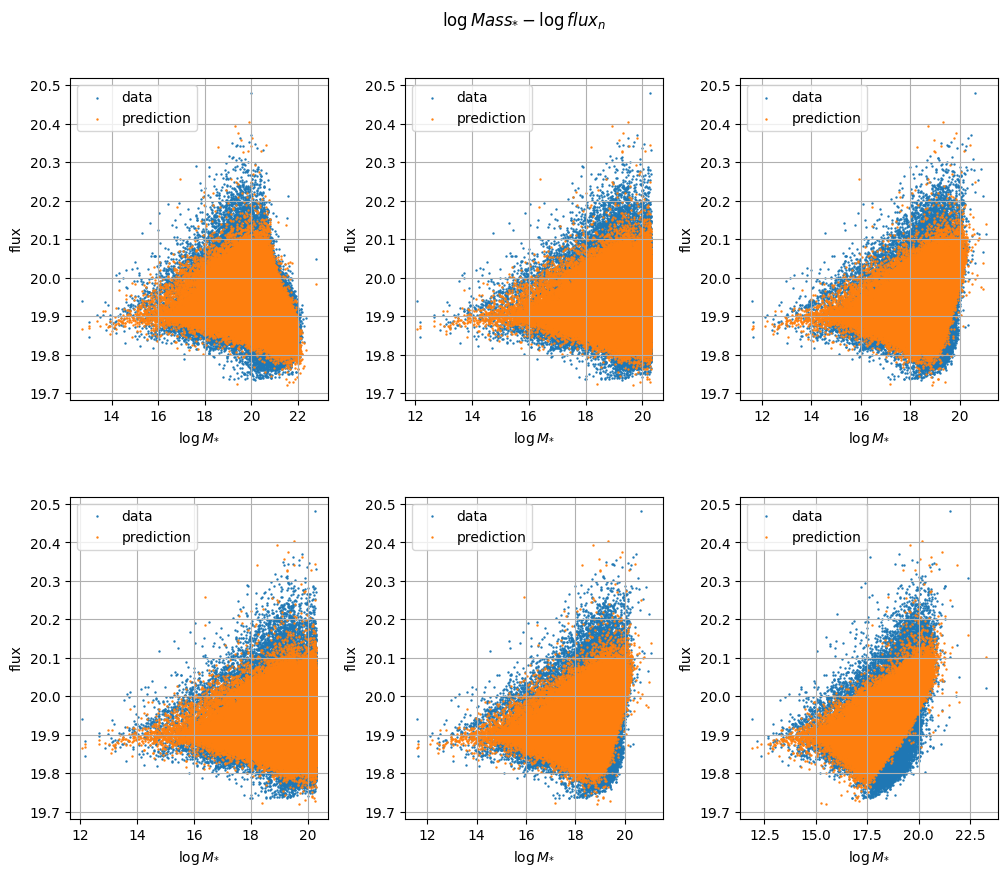

In [14]:
nrows, ncols =  3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'$\log{Mass_{*}} - \log{flux_{n}}$', y=1.06)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
X_test = np.array(X_test)
for i in range(2):
    for j in range(3):
        axes[i, j].scatter(X_test[:,i+j], y_test, s=0.5, label='data') #data
        axes[i, j].scatter(X_test[:,i+j], y_pred, s=0.5, label='prediction') #predictions
        axes[i, j].legend()
        axes[i, j].set_title('')
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel('flux')
        axes[i, j].grid()

plt.show()

### Random Forest

In [25]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.00035664561165556756


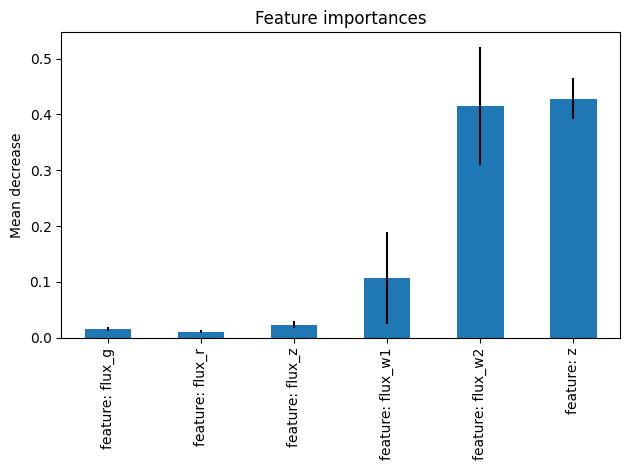

In [27]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

feature_names = [f"feature: {i}" for i in props]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

In [28]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

In [29]:
nodes, _, _ = graph_r(rosettes[6])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.999, random_state=42)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0003997837909853285


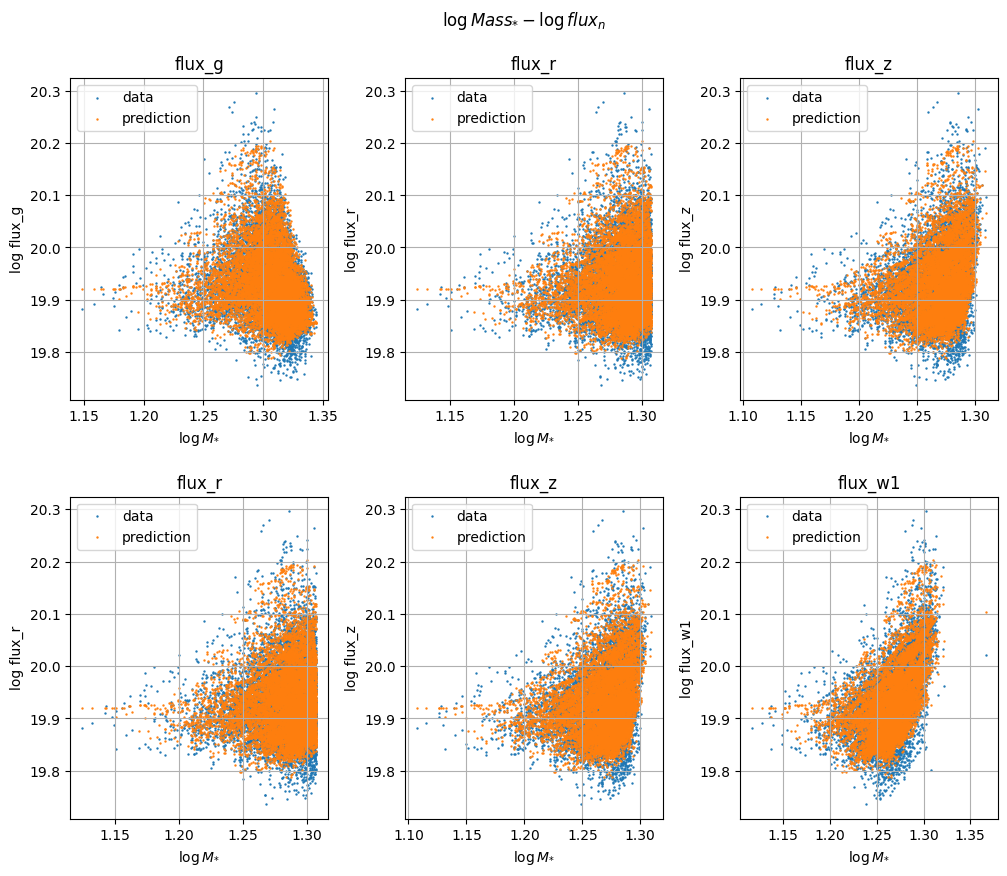

In [30]:
X_test = np.log10(np.array(X_test))
labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

nrows, ncols =  3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'$\log{Mass_{*}} - \log{flux_{n}}$', y=1.06)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(2):
    for j in range(3):
        axes[i, j].scatter(X_test[:,i+j], y_test, s=0.5, label='data') #data
        axes[i, j].scatter(X_test[:,i + j], y_pred, s=0.5, label='prediction') #predictions
        axes[i, j].legend()
        axes[i, j].set_title(labels[i+j])
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {labels[i+j]}')
        axes[i, j].grid()

plt.show()